https://github.com/nsinha280/lstm-on-Yelp-review-data/blob/master/lstm-final.ipynb

In [ ]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
df_reviews=pd.read_csv('yelp.csv')
df_reviews=df_reviews[['text', 'stars']]
df_reviews.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


In [ ]:
pd.set_option('mode.chained_assignment', None)
df_reviews["labels"] = df_reviews["stars"].apply(lambda x: -1 if x < 3  else (1 if x > 3 else 0))
df_reviews = df_reviews.drop("stars",axis=1)

df_reviews

,text,labels
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1
...,...,...
9995,First visit...Had lunch here today - used my G...,0
9996,Should be called house of deliciousness!\n\nI ...,1
9997,I recently visited Olive and Ivy for business ...,1
9998,My nephew just moved to Scottsdale recently so...,-1


In [ ]:
def split_df(df_reviews):
    n_rows = len(df_reviews)
    ind = np.random.permutation(n_rows)
    df_reviews = df_reviews.iloc[ind,:]
    df_train = df_reviews.iloc[:int(0.8*n_rows),:]
    df_val = df_reviews.iloc[int(0.8*n_rows):int(0.9*n_rows),:]
    df_test = df_reviews.iloc[int(0.9*n_rows):,:]

    return df_train, df_val, df_test

In [ ]:
n_rows = len(df_reviews)
dfs_train, dfs_val, dfs_test = [],[],[]
gb = df_reviews.groupby('labels')
for x in gb.groups:
    group = gb.get_group(x)
    df_train, df_val, df_test = split_df(group)
    dfs_train.append(df_train)
    dfs_val.append(df_val)
    dfs_test.append(df_test)
df_train = pd.concat(dfs_train, ignore_index=True)
ind = np.random.permutation(len(df_train))
df_train = df_train.iloc[ind,:]
df_val = pd.concat(dfs_val, ignore_index=True)
ind = np.random.permutation(len(df_val))
df_val = df_val.iloc[ind,:]
df_test = pd.concat(dfs_test, ignore_index=True)
ind = np.random.permutation(len(df_test))
df_test = df_test.iloc[ind,:]
print(f'Number of training examples: {len(df_train)}')
print(f'Number of validation examples: {len(df_val)}')
print(f'Number of test examples: {len(df_test)}')

Number of training examples: 7998
Number of validation examples: 1000
Number of test examples: 1002


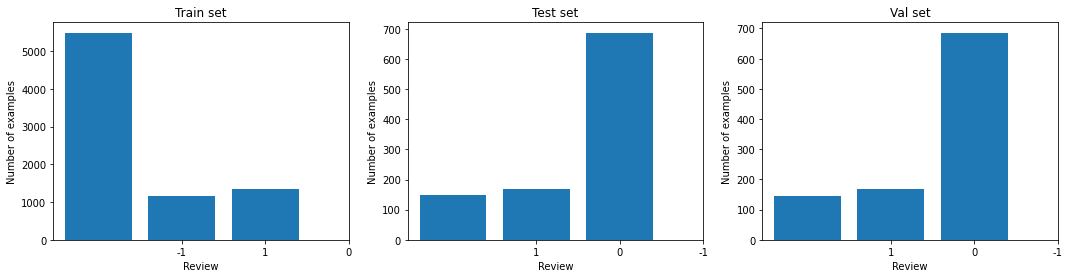

In [ ]:
fig = plt.figure(figsize=(18,4))
titles = ['Train set','Test set','Val set']
for i,dataf in enumerate([df_train,df_test,df_val]):
    ax = fig.add_subplot(1,3,i+1)
    Y, labels = pd.factorize(dataf['labels'])
    ax.bar(labels, height=pd.Series(Y).value_counts())
    ax.set_xticks(ticks=range(len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_xlabel('Review')
    ax.set_ylabel('Number of examples')
    ax.set_title(titles[i])


In [ ]:
%pip install hydra-core
%pip install omegaconf
%pip install sentencepiece
%pip install transformers
%pip install bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.3 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=1264b839c9223700c32b4dd3677bdfb06ccbaa00977edd2b779f30c0555cb129
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 10.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle
from transformers import XLMRobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import SGD

In [ ]:
%pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 8.6 MB/s eta 0:00:00


In [ ]:
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.base', force_reload=True)
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

Downloading: "https://github.com/pytorch/fairseq/zipball/main" to /root/.cache/torch/hub/main.zip


running build_ext


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))


cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp
cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/fairseq
creating build/temp.linux-x86_64-3.8/fairseq/clib
creating build/temp.linux-x86_64-3.8/fairseq/clib/libbleu
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c fairseq/clib/libbleu/libbleu.cpp -o build/temp.linux-x86_64-3.8/fairseq/clib/libbleu/libbleu.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE="_gcc" -DPYBIND11_STDLIB="_libstdcpp" -DPYBIND11_BUILD_ABI="_cxxabi1011" -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX

TypeError: ignored

for errors check: https://github.com/facebookresearch/fairseq/issues/1070


In [ ]:
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange
import time

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

NameError: ignored

In [ ]:
%pip install regex requests hydra-core omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_main


running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/fairseq
creating build/temp.linux-x86_64-3.8/fairseq/clib
creating build/temp.linux-x86_64-3.8/fairseq/clib/libbleu
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c fairseq/clib/libbleu/libbleu.cpp -o build/temp.linux-x86_64-3.8/fairseq/clib/libbleu/libbleu.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE="_gcc" -DPYBIND11_STDLIB="_libstdcpp" -DPYBIND11_BUILD_ABI="_cxxabi1011" -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX11_ABI=0
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEB

TypeError: ignored